<a href="https://colab.research.google.com/github/ramapriyakp/Portfolio/blob/master/NLP/Shakespeare_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation using LSTMs
Text Generation is a type of Language Modelling problem. Language Modelling is the core problem for a number of of natural language processing tasks such as speech to text, conversational system, and text summarization.

A trained language model learns the likelihood of occurrence of a word based on the previous sequence of words used in the text. Language models can be operated at character level, n-gram level, sentence level or even paragraph level. In this notebook, we will create a language model for generating natural language text by implement and training state-of-the-art Recurrent Neural Network

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
 
# Figure out how to import regularizers
import tensorflow.keras.regularizers as regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Class Tokenizer
Text tokenization utility class.

This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
(each integer being the index of a token in a dictionary) or into a vector where the coefficient
for each token could be binary, based on word count, based on tf-idf...

**fit_on_texts(texts)**

Updates internal vocabulary based on a list of texts.
In the case where texts contains lists, we assume each entry of the lists to be a token.

In [0]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2019-08-30 16:14:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.160.16, 2404:6800:4003:80d::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.160.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2019-08-30 16:14:25 (109 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [0]:
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Activation

## 4. LSTMs for Text Generation
 Recurrent neural networks have shown a good performance in sequence to sequence learning and text data applications. Lets look at them in brief.



![](http://www.shivambansal.com/blog/text-lstm/2.png)

Unlike Feed-forward neural networks in which activation outputs are propagated only in one direction, the activation outputs from neurons propagate in both directions (from inputs to outputs and from outputs to inputs) in Recurrent Neural Networks. This creates loops in the neural network architecture which acts as a ‘memory state’ of the neurons. This state allows the neurons an ability to remember what have been learned so far.

The memory state in RNNs gives an advantage over traditional neural networks but a problem called Vanishing Gradient is associated with them. In this problem, while learning with a large number of layers, it becomes really hard for the network to learn and tune the parameters of the earlier layers. To address this problem, A new type of RNNs called LSTMs (Long Short Term Memory) Models have been developed.

LSTMs have an additional state called ‘cell state’ through which the network makes adjustments in the information flow. The advantage of this state is that the model can remember or forget the leanings more selectively. To learn more about LSTMs, here is a great post. Lets architecture a LSTM model in our code. I have added total three layers in the model.

1. Input Layer : Takes the sequence of words as input.Keras offers an Embedding layer that can be used for neural networks on text data.
2. LSTM Layer : Computes the output using LSTM units. I have added 100 units in the layer, but this number can be fine tuned later.
3. Dropout Layer : A regularisation layer which randomly turns-off the activations of some neurons in the LSTM layer. It helps in preventing over fitting. (Optional Layer)
4. Output Layer : Computes the probability of the best possible next word as output

We will run this model for total 100 epoochs but it can be experimented further.






In [0]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))

print(model.summary())

W0830 16:14:37.407517 140239690790784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 16:14:37.434170 140239690790784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 16:14:37.440778 140239690790784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 200)           160800    
_________________________________________________________________
dropout (Dropout)            (None, 10, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                50200     
_________________________________________________________________
dense (Dense)                (None, 1605)              81855     
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 5,770,821
Trainable params: 5,770,821
Non-trainable params: 0
______________________________________________

In [0]:
# Pick an optimizer
from tensorflow.keras.optimizers import Adam
adam = Adam(lr=0.01)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint

history_with_reg = History()
es = EarlyStopping(patience=10, monitor='acc')
mc = ModelCheckpoint("seq_model_with_reg.h5", monitor='acc', 
                     save_best_only=True, load_weights_on_restart=True)

In [0]:
model.fit(predictors, label, epochs=100, verbose=1, callbacks=[history_with_reg, mc])

W0830 16:15:16.600243 140239690790784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
15462/15462 [==============================] - 26s 2ms/sample - loss: 6.8844 - acc: 0.0213
Epoch 2/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 6.4994 - acc: 0.0219
Epoch 3/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 6.3952 - acc: 0.0243
Epoch 4/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.2692 - acc: 0.0279
Epoch 5/100
15462/15462 [==============================] - 25s 2ms/sample - loss: 6.1805 - acc: 0.0328
Epoch 6/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 6.1051 - acc: 0.0369
Epoch 7/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 6.0250 - acc: 0.0391
Epoch 8/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 5.9548 - acc: 0.0418
Epoch 9/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 5.8745 - acc: 0.0476
Epoch 10/100
15462/15462 [==============================] - 24s 2ms/sampl

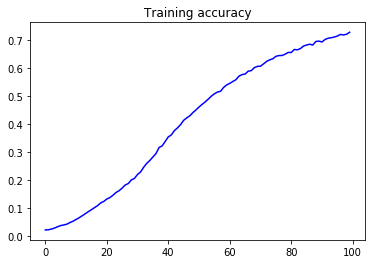

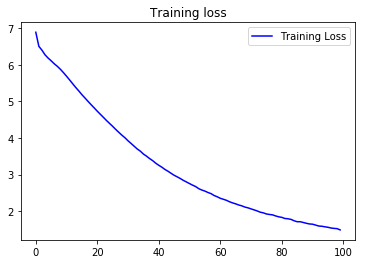

In [0]:
history = history_with_reg

import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## 5. Generating the text 

Great, our model architecture is now ready and we can train it using our data. Next lets write the function to predict the next word based on the input words (or seed text). We will first tokenize the seed text, pad the sequences and pass into the trained model to get predicted word. The multiple predicted words can be appended together to get predicted sequence.

In [0]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope or this viewest survey gems wit green weep decays this ride lie in me a show good show many forth brow 'will ' ' still have behold and give stay away be much strong part bright bright show thee told thee worth told it most 'will' is loving shouldst confound dispense else mistaking seen seen strive not back of done no odours made to stay things skill give store now give harvest cross'd kill'd kill'd cross'd proceed remain need interest days can see down thence give groan new cheeks wretch suspect and mine eye be of heart so show it
